In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define file paths
zip_file_path = '/content/drive/MyDrive/InfinityAI_InfiniteRep_overheadpress_v1.0.zip'
extract_path = '/content/dataset'

# Create directory for extraction
os.makedirs(extract_path, exist_ok=True)

# Extract ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete.")


Mounted at /content/drive
Extraction complete.


In [ ]:
import os
import cv2
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

In [ ]:
import matplotlib.pyplot as plt
import json
import os
import os
import cv2
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import mobilenet_v2
import cv2
import json
import torch
import cv2
import json
from torchvision import models, transforms
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo


In [ ]:
import cv2
import json

# Path to the input video file
video_path = '/content/dataset/data/000000.mp4'

# Initialize video capture from the specified video file
cap = cv2.VideoCapture(video_path)

# Define the structure for annotations
annotations = {
    "info": {
        "url": "https://toinfinity.ai/",  # Metadata information
        "date_created": "20240815_000000",  # Date of creation in YYYYMMDD_HHMMSS format
        # Add other necessary metadata here if needed
    },
    "categories": [
        {
            "id": 0,
            "name": "person",  # Category of the object (e.g., person)
            "keypoints": [
                "nose", "left_eye", "right_eye", "left_ear", "right_ear",
                "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
                "left_wrist", "right_wrist", "left_hip", "right_hip",
                "left_knee", "right_knee", "left_ankle", "right_ankle"
            ],  # List of keypoints for human pose estimation
            "skeleton": [
                [16, 14], [14, 12], [17, 15], [15, 13], [12, 13],
                [6, 12], [7, 13], [6, 7], [6, 8], [7, 9],
                [8, 10], [9, 11], [2, 3], [1, 2], [1, 3],
                [2, 4], [3, 5], [4, 6], [5, 7]
            ]  # Skeleton structure linking keypoints
        }
    ],
    "images": [],        # List to store image metadata
    "annotations": []    # List to store annotations for each image
}

frame_id = 0
success = True

# Process each frame of the video
while success:
    success, frame = cap.read()  # Read the next frame from the video
    if success:
        # Generate the filename for the current frame and save it as an image
        frame_filename = f'frame_{frame_id}.jpg'
        cv2.imwrite(frame_filename, frame)

        # Create metadata for the current frame
        image_info = {
            "id": frame_id,               # Unique identifier for the frame
            "width": frame.shape[1],      # Width of the frame
            "height": frame.shape[0],     # Height of the frame
            "file_name": frame_filename,  # Filename of the saved image
            "rep_count": 0.0,             # Placeholder for repetition count, if applicable
            "frame_number": frame_id      # Frame number in the video sequence
        }
        annotations["images"].append(image_info)  # Add the image info to the annotations

        # Example annotation (should be replaced with actual keypoint detection results)
        keypoints = [0] * 51  # Placeholder for keypoints (17 keypoints x 3 values each: x, y, visibility)
        annotation = {
            "image_id": frame_id,                 # ID of the image the annotation corresponds to
            "category_id": 0,                     # ID of the category (e.g., person)
            "keypoints": keypoints,               # List of keypoints for the person in the image
            "num_keypoints": 17,                  # Number of keypoints
            "bbox": [0, 0, frame.shape[1], frame.shape[0]],  # Bounding box (covering the whole image)
            "score": 1.0  # Confidence score placeholder (if applicable)
        }
        annotations["annotations"].append(annotation)  # Add the annotation to the list

        frame_id += 1  # Increment frame ID for the next iteration

# Save the annotations to a JSON file
output_json_path = '/content/dataset/output_annotations.json'
with open(output_json_path, 'w') as f:
    json.dump(annotations, f, indent=4)  # Save annotations with indentation for readability

# Release the video capture object to free resources
cap.release()


In [ ]:
import cv2
import json
import torch
from torchvision import models, transforms
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Initialize Mask R-CNN model for object detection and segmentation
model = models.detection.maskrcnn_resnet50_fpn(weights="COCO_V1")
model.eval()

# Initialize Detectron2 model for keypoint detection
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the threshold for keypoint detection
predictor = DefaultPredictor(cfg)

# Video file path and output path for annotations
video_path = "/content/dataset/data/000000.mp4"
output_json_path = "video_annotation.json"

# Open the video file
cap = cv2.VideoCapture(video_path)

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Transform function for model input
transform = transforms.Compose([transforms.ToTensor()])

# Initialize JSON structure for annotations
annotation_data = {
    "info": {
        "camera_pitch": 90.0,  # Example value for camera pitch
        "camera_height": 1.5,  # Example value for camera height
        "fps": fps
    },
    "categories": [
        {
            "id": 0,
            "name": "person",
            "keypoints": ["nose", "left_eye", "right_eye", "left_ear", "right_ear",
                          "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
                          "left_wrist", "right_wrist", "left_hip", "right_hip",
                          "left_knee", "right_knee", "left_ankle", "right_ankle"]
        }
    ],
    "images": [],
    "annotations": []
}

# Process each frame in the video
frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB for model compatibility
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Transform frame and add batch dimension
    frame_tensor = transform(frame_rgb).unsqueeze(0)

    # Object detection and segmentation with Mask R-CNN
    with torch.no_grad():
        outputs = model(frame_tensor)

    # Extract bounding boxes, masks, and labels from Mask R-CNN output
    boxes = outputs[0]['boxes'].cpu().numpy()
    masks = outputs[0]['masks'].cpu().numpy()
    labels = outputs[0]['labels'].cpu().numpy()

    # Keypoint detection with Detectron2
    keypoint_outputs = predictor(frame_rgb)
    keypoints = keypoint_outputs["instances"].pred_keypoints.cpu().numpy()

    # Store image metadata
    image_info = {
        "id": frame_number,
        "width": frame_width,
        "height": frame_height,
        "rep_count": 1.0,  # Example value for repetition count
        "frame_number": frame_number
    }
    annotation_data["images"].append(image_info)

    # Ensure the number of detected keypoints matches the number of detected boxes
    num_detections = min(len(boxes), len(keypoints))

    # Store annotations for each detection
    for i in range(num_detections):
        annotation = {
            "category_id": labels[i],
            "image_id": frame_number,
            "id": i,
            "iscrowd": 0,
            "bbox": boxes[i].tolist(),
            "segmentation": masks[i].tolist(),
            "keypoints": keypoints[i].flatten().tolist()
        }
        annotation_data["annotations"].append(annotation)

    frame_number += 1

# Release the video capture object
cap.release()

# Save annotations to a JSON file
with open(output_json_path, "w") as f:
    json.dump(annotation_data, f, indent=4)

print(f"Annotations saved to {output_json_path}")


In [ ]:
import cv2
import os

data_dir = '/content/dataset/data'  # Root directory containing all videos and annotations

def extract_frames_from_videos(data_dir):
    for item in os.listdir(data_dir):
        if item.endswith('.mp4'):
            video_file = os.path.join(data_dir, item)
            video_id = item.split('.')[0]
            frames_output_dir = os.path.join(data_dir, f"{video_id}_frames")
            os.makedirs(frames_output_dir, exist_ok=True)

            cap = cv2.VideoCapture(video_file)
            success, frame = cap.read()
            count = 0
            while success:
                frame_filename = os.path.join(frames_output_dir, f"frame_{count:06d}.jpg")
                cv2.imwrite(frame_filename, frame)
                success, frame = cap.read()
                count += 1
            cap.release()
            print(f"Extracted {count} frames from {video_file}")

extract_frames_from_videos(data_dir)

Extracted 661 frames from /content/dataset/data/000024.mp4
Extracted 442 frames from /content/dataset/data/000013.mp4
Extracted 272 frames from /content/dataset/data/000041.mp4
Extracted 325 frames from /content/dataset/data/000097.mp4
Extracted 418 frames from /content/dataset/data/000091.mp4
Extracted 297 frames from /content/dataset/data/000078.mp4
Extracted 294 frames from /content/dataset/data/000001.mp4
Extracted 342 frames from /content/dataset/data/000011.mp4
Extracted 417 frames from /content/dataset/data/000005.mp4
Extracted 332 frames from /content/dataset/data/000098.mp4
Extracted 847 frames from /content/dataset/data/000058.mp4
Extracted 315 frames from /content/dataset/data/000004.mp4
Extracted 251 frames from /content/dataset/data/000028.mp4
Extracted 277 frames from /content/dataset/data/000064.mp4
Extracted 346 frames from /content/dataset/data/000095.mp4
Extracted 380 frames from /content/dataset/data/000057.mp4
Extracted 211 frames from /content/dataset/data/000075.m

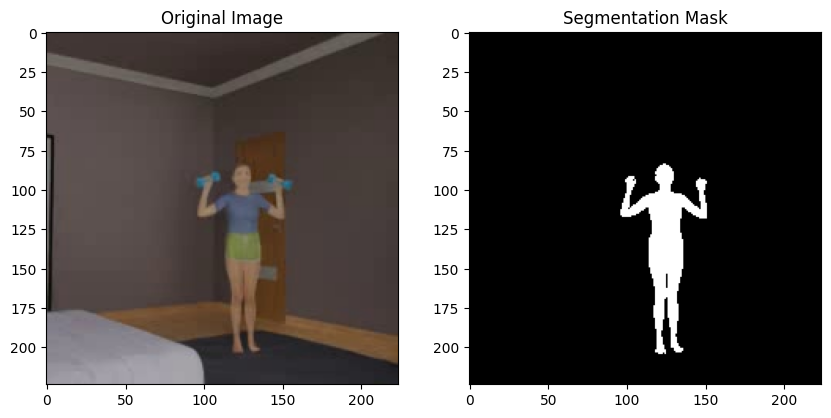

In [ ]:
import zipfile

def extract_zip(zip_file, extract_to):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Extract segmentation masks
for item in os.listdir(data_dir):
    if item.endswith('_img_labels.zip'):
        zip_file = os.path.join(data_dir, item)
        extract_to = os.path.join(data_dir, item.split('_img_labels.zip')[0] + '_img_labels')
        extract_zip(zip_file, extract_to)

def visualize_segmentation(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Segmentation Mask')
    plt.show()

# Example paths
image_path = os.path.join(data_dir, '000000_frames/frame_000000.jpg')
mask_path = os.path.join(data_dir, '000000_img_labels/image.000000.iseg.000000.png')
visualize_segmentation(image_path, mask_path)


In [ ]:


def parse_annotations(data_dir):
    annotations = {}
    for item in os.listdir(data_dir):
        if item.endswith('.json'):
            json_file = os.path.join(data_dir, item)
            video_id = item.split('.')[0]
            with open(json_file, 'r') as f:
                annotations[video_id] = json.load(f)
    return annotations

annotations = parse_annotations(data_dir)


In [ ]:
# iterate over annotation jsons for each video and extract labels
exercise_folder  = '/content/dataset/data'
json_paths = sorted(glob.glob(os.path.join(exercise_folder, "*.json")))
metadata = []
for json_path in json_paths:
    coco = COCO(json_path)
    percent_in_fov = []
    percent_occlusion = []
    for ann in coco.anns.values():
        if coco.cats[ann["category_id"]]["name"] != "person":
            # skip any non-person annotations (e.g. for dumbbells)
            continue
        percent_in_fov.append(ann["percent_in_fov"])
        percent_occlusion.append(ann["percent_occlusion"])
    avg_percent_in_fov = np.mean(percent_in_fov)  # average across frames
    avg_percent_occlusion = np.mean(percent_occlusion)  # average across frames
    metadata.append({
        "video_number": coco.dataset["info"]["video_number"],
        "avg_percent_in_fov": avg_percent_in_fov,
        "avg_percent_occlusion": avg_percent_occlusion,
        "camera_height": coco.dataset["info"]["camera_height"],
    })
metadata_df = pd.DataFrame(metadata)

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
load

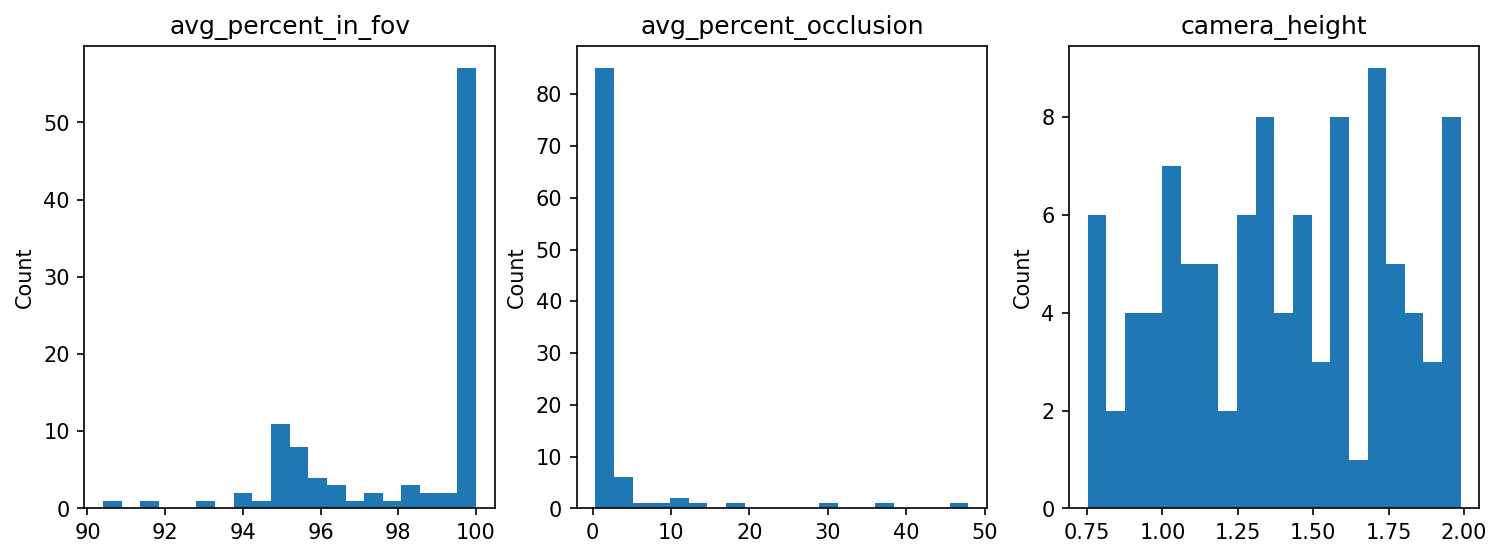

In [ ]:
num_bins = 20
cols_to_plot = ["avg_percent_in_fov", "avg_percent_occlusion", "camera_height"]
fig, ax = plt.subplots(1,len(cols_to_plot),figsize=(12,4), dpi=150)
for i, col_to_plot in enumerate(cols_to_plot):
    ax[i].hist(metadata_df[col_to_plot], bins=num_bins)
    ax[i].set_title(col_to_plot)
    ax[i].set_ylabel('Count')
plt.show()

In [ ]:
def plot_examples(plot_df: pd.DataFrame, num_to_plot: int, title: str):
    """Displays first frame of leading N videos in dataframe."""
    fig,ax = plt.subplots(1,num_to_plot,figsize=(4*num_to_plot,4))
    for i, (_, video_data) in enumerate(plot_df[:num_to_plot].iterrows()):
        video_path = os.path.join(exercise_folder, f"{int(video_data['video_number']):06d}.mp4")
        vidcap = cv2.VideoCapture(video_path)
        success, img = vidcap.read()
        ax[i].imshow(img[:,:,::-1])
        ax[i].set_title(f"Video number: {int(video_data['video_number'])}")
        ax[i].axis("off")
    fig.suptitle(title)
    plt.show()

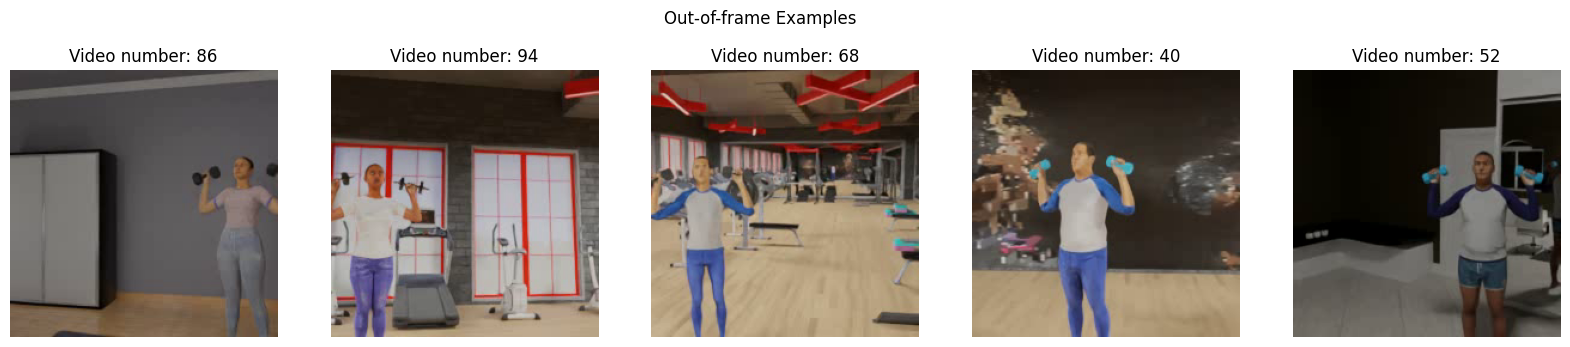

In [ ]:
examples_out_of_frame = metadata_df.sort_values(by="avg_percent_in_fov", ascending=True)
plot_examples(examples_out_of_frame, num_to_plot=5, title="Out-of-frame Examples")

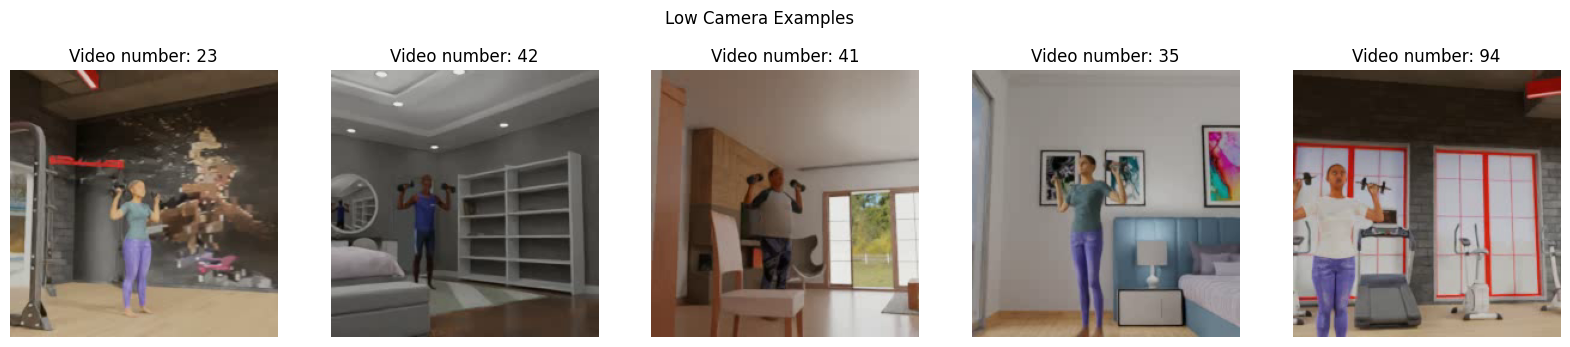

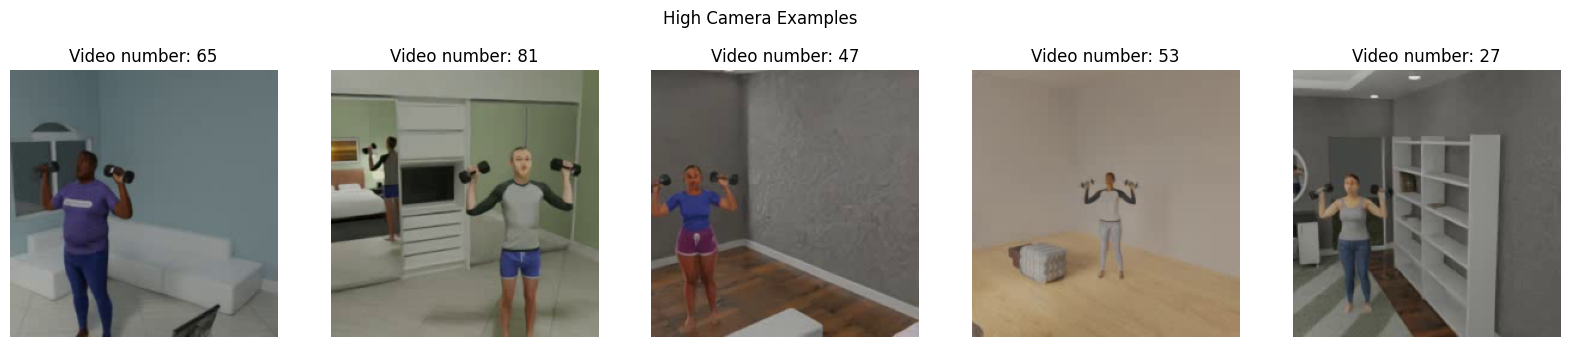

In [ ]:
examples_low_cam = metadata_df.sort_values(by="camera_height", ascending=True)
examples_high_cam = metadata_df.sort_values(by="camera_height", ascending=False)

plot_examples(examples_low_cam, num_to_plot=5, title="Low Camera Examples")
plot_examples(examples_high_cam, num_to_plot=5, title="High Camera Examples")

In [ ]:
video_number = 0

video_path = os.path.join(exercise_folder, f"{video_number:06d}.mp4")
json_path = os.path.join(exercise_folder, f"{video_number:06d}.json")

In [ ]:
coco = COCO(json_path)
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
imgs = []
while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        break
    imgs.append(img)
imgs = np.array(imgs)

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


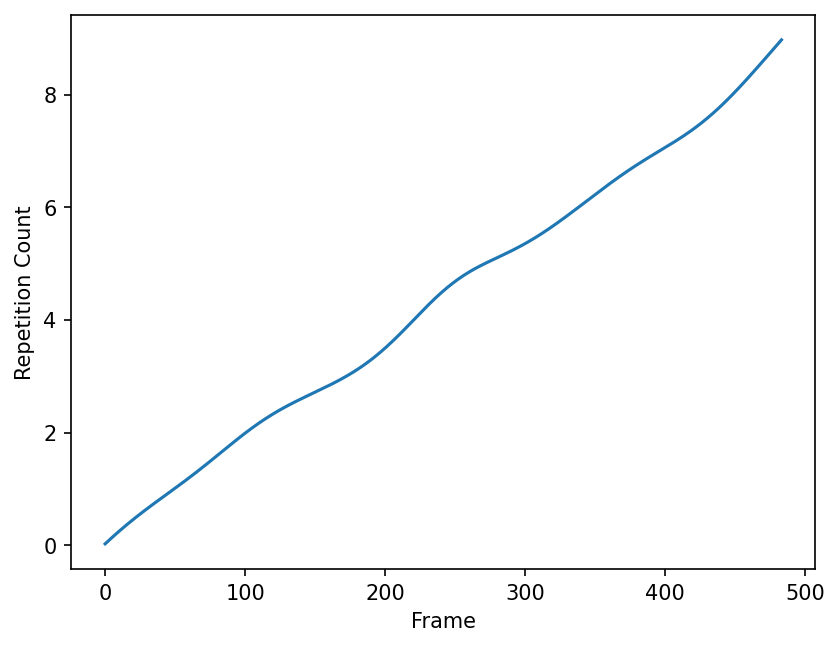

In [ ]:
rep_counts = [img_data["rep_count"] for img_data in coco.imgs.values()]
fig,ax = plt.subplots(dpi=150)
ax.plot(rep_counts)
ax.set_xlabel("Frame")
ax.set_ylabel("Repetition Count")
plt.show()

In [ ]:
output_path = "./output/"
os.makedirs(output_path, exist_ok=True)

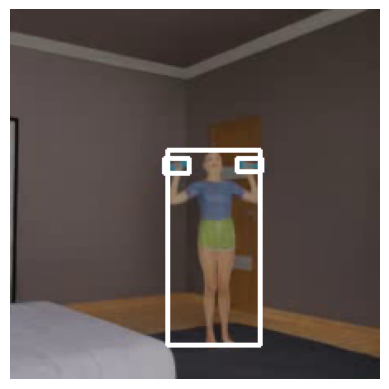

In [ ]:
bb_path = os.path.join(output_path, "bbox.mp4")

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
image_dims = (224,224)
out = cv2.VideoWriter(bb_path, fourcc, fps, image_dims)

for img, img_data in zip(imgs, coco.imgs.values()):
    canvas = img.copy()
    img_id = img_data["id"]
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    for ann in anns:
        x,y,w,h = tuple(np.array(ann["bbox"]).astype(int))
        cv2.rectangle(canvas, (x,y), (x+w, y+h), color=(255,255,255), thickness=2)
    out.write(canvas)
out.release()

plt.imshow(canvas[:,:,::-1])
plt.axis("off")
plt.show()

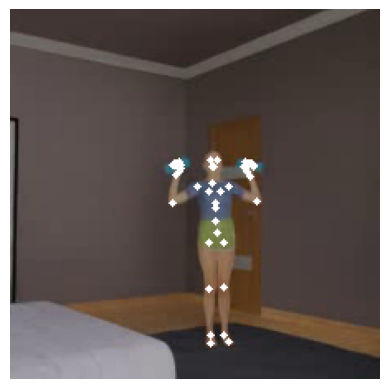

In [ ]:
kp_path = os.path.join(output_path, "keypoints.mp4")
out = cv2.VideoWriter(kp_path, fourcc, fps, image_dims)

for img, img_data in zip(imgs, coco.imgs.values()):
    canvas = img.copy()
    img_id = img_data["id"]
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    for ann in anns:
        # skip non-person instances
        if "armature_keypoints" not in ann:
            continue
        keypoints = ann["armature_keypoints"]
        for keypoint_name, keypoint_info in keypoints.items():
            x, y = keypoint_info["x"], keypoint_info["y"]
            cv2.circle(canvas, (x, y), radius=2, color=(255,255,255), thickness=-1)
    out.write(canvas)
out.release()

plt.imshow(canvas[:,:,::-1])
plt.axis("off")
plt.show()

In [ ]:
import json

# Define the data structure
data = [
    ["pelvis", "left_hip"],
    ["left_hip", "left_knee"],
    ["left_knee", "left_ankle"],
    ["left_ankle", "left_foot"],
    ["pelvis", "right_hip"],
    ["right_hip", "right_knee"],
    ["right_knee", "right_ankle"],
    ["right_ankle", "right_foot"],
    ["pelvis", "spine1"],
    ["spine1", "spine2"],
    ["spine2", "spine3"],
    ["spine3", "neck"],
    ["neck", "head"],
    ["head", "jaw"],
    ["head", "left_eye_smplhf"],
    ["head", "right_eye_smplhf"],
    ["spine3", "left_collar"],
    ["left_collar", "left_shoulder"],
    ["left_shoulder", "left_elbow"],
    ["left_elbow", "left_wrist"],
    ["left_wrist", "left_index1"],
    ["left_index1", "left_index2"],
    ["left_index2", "left_index3"],
    ["left_wrist", "left_middle1"],
    ["left_middle1", "left_middle2"],
    ["left_middle2", "left_middle3"],
    ["left_wrist", "left_pinky1"],
    ["left_pinky1", "left_pinky2"],
    ["left_pinky2", "left_pinky3"],
    ["left_wrist", "left_ring1"],
    ["left_ring1", "left_ring2"],
    ["left_ring2", "left_ring3"],
    ["left_wrist", "left_thumb1"],
    ["left_thumb1", "left_thumb2"],
    ["left_thumb2", "left_thumb3"],
    ["spine3", "right_collar"],
    ["right_collar", "right_shoulder"],
    ["right_shoulder", "right_elbow"],
    ["right_elbow", "right_wrist"],
    ["right_wrist", "right_index1"],
    ["right_index1", "right_index2"],
    ["right_index2", "right_index3"],
    ["right_wrist", "right_middle1"],
    ["right_middle1", "right_middle2"],
    ["right_middle2", "right_middle3"],
    ["right_wrist", "right_pinky1"],
    ["right_pinky1", "right_pinky2"],
    ["right_pinky2", "right_pinky3"],
    ["right_wrist", "right_ring1"],
    ["right_ring1", "right_ring2"],
    ["right_ring2", "right_ring3"],
    ["right_wrist", "right_thumb1"],
    ["right_thumb1", "right_thumb2"],
    ["right_thumb2", "right_thumb3"]
]

# Write the data to a JSON file
with open('armature_connections.json', 'w') as json_file:
    json.dump(data, json_file, indent=4)

print("JSON file 'body_connections.json' has been created successfully.")

JSON file 'body_connections.json' has been created successfully.


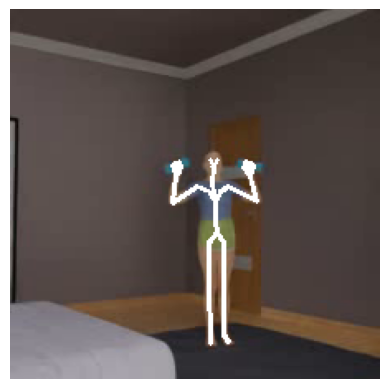

In [ ]:
kp_connections = json.load(open('armature_connections.json','r'))

skel_path = os.path.join(output_path, "skeleton.mp4")
out = cv2.VideoWriter(skel_path, fourcc, fps, image_dims)

for img, img_data in zip(imgs, coco.imgs.values()):
    canvas = img.copy()
    img_id = img_data["id"]
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    for ann in anns:
        # skip non-person instances
        if "armature_keypoints" not in ann:
            continue
        keypoints = ann["armature_keypoints"]
        for parent, child in kp_connections:
            x0 = keypoints[parent]["x"]
            y0 = keypoints[parent]["y"]
            x1 = keypoints[child]["x"]
            y1 = keypoints[child]["y"]
            cv2.line(canvas, (x0, y0), (x1,y1), color=(255,255,255), thickness=2)
    out.write(canvas)
out.release()

plt.imshow(canvas[:,:,::-1])
plt.axis("off")
plt.show()

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ExerciseDataset(Dataset):
    def __init__(self, annotations, data_dir, transform=None):
        """
        Initializes the ExerciseDataset.

        Args:
            annotations (dict): Dictionary containing annotations for each video.
            data_dir (str): Directory where frame images and label masks are stored.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.annotations = annotations
        self.data_dir = data_dir
        self.transform = transform
        self.samples = []

        # Iterate through each video in annotations
        for video_id, video_annotations in annotations.items():
            frames_dir = os.path.join(data_dir, f"{video_id}_frames")
            labels_dir = os.path.join(data_dir, f"{video_id}_img_labels")

            # Collect sample paths and info for each image in the video
            for image_info in video_annotations['images']:
                frame_number = image_info['id']
                frame_path = os.path.join(frames_dir, f"frame_{frame_number:06d}.jpg")
                cseg_path = os.path.join(labels_dir, f"image.{frame_number:06d}.cseg.png")
                if os.path.exists(frame_path) and os.path.exists(cseg_path):
                    self.samples.append((frame_path, cseg_path, video_id, frame_number, image_info))

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
                - Image tensor
                - Segmentation mask tensor
                - Keypoints tensor
        """
        frame_path, cseg_path, video_id, frame_number, image_info = self.samples[idx]

        # Load and preprocess the image
        image = cv2.imread(frame_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = image / 255.0  # Normalize image

        # Load and preprocess the segmentation mask
        cseg_mask = cv2.imread(cseg_path, cv2.IMREAD_GRAYSCALE)
        cseg_mask = cv2.resize(cseg_mask, (224, 224))
        cseg_mask = np.expand_dims(cseg_mask, axis=-1)  # Add channel dimension
        cseg_mask = cseg_mask / 255.0  # Normalize mask

        # Retrieve keypoints for the current frame
        keypoints = np.zeros((17, 3))  # Default to zeros if no keypoints are found
        for annotation in self.annotations[video_id]['annotations']:
            if annotation['image_id'] == frame_number:
                keypoints = annotation.get('keypoints', [])
                if keypoints:
                    keypoints = np.array(keypoints, dtype=np.float64).reshape(-1, 3)
                    keypoints[:, 0] /= image_info['width']
                    keypoints[:, 1] /= image_info['height']
                break

        # Convert numpy arrays to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        cseg_mask = torch.tensor(cseg_mask, dtype=torch.float32).permute(2, 0, 1)
        keypoints = torch.tensor(keypoints, dtype=torch.float32)

        return image, cseg_mask, keypoints

# Define the transformations (if any)
transform = transforms.Compose([transforms.ToTensor()])

# Instantiate the dataset and dataloader
dataset = ExerciseDataset(annotations, data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

print(f"Loaded dataset with {len(dataset)} frames")


Loaded dataset with 12738 frames


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class MultiTaskModel(nn.Module):
    def __init__(self, num_keypoints=17):
        """
        Initializes the MultiTaskModel.

        Args:
            num_keypoints (int): Number of keypoints to predict.
        """
        super(MultiTaskModel, self).__init__()

        # Load the pre-trained MobileNetV2 model
        mobilenet_v2 = models.mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')

        # Extract the features part from MobileNetV2
        self.features = mobilenet_v2.features

        # Define the segmentation head
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(1280, 512, kernel_size=3, padding=1),  # Convolutional layer to reduce feature channels
            nn.ReLU(),                                       # Activation function
            nn.ConvTranspose2d(512, 256, kernel_size=3, padding=1),  # Upsampling layer
            nn.ReLU(),                                       # Activation function
            nn.Upsample(scale_factor=2),                    # Upsample the feature maps
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1),  # Upsampling layer
            nn.ReLU(),                                       # Activation function
            nn.Upsample(scale_factor=2),                    # Upsample the feature maps
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),   # Upsampling layer
            nn.ReLU(),                                       # Activation function
            nn.Upsample(scale_factor=2),                    # Upsample the feature maps
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),    # Upsampling layer
            nn.ReLU(),                                       # Activation function
            nn.Upsample(scale_factor=2),                    # Upsample the feature maps
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),    # Upsampling layer
            nn.ReLU(),                                       # Activation function
            nn.Upsample(scale_factor=2),                    # Upsample the feature maps
            nn.Conv2d(16, 1, kernel_size=1),                # Final convolution to output the segmentation mask
            nn.Sigmoid()                                    # Sigmoid activation for binary segmentation mask
        )

        # Define the keypoint detection head
        self.keypoint_head = nn.Sequential(
            nn.Flatten(),                                  # Flatten the feature maps
            nn.Linear(1280 * 7 * 7, 1024),                # Fully connected layer to reduce dimensions
            nn.ReLU(),                                    # Activation function
            nn.Linear(1024, num_keypoints * 3)            # Output layer to predict keypoints (x, y, visibility) for each keypoint
        )

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (N, C, H, W) where N is batch size, C is number of channels, H is height, W is width.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]:
                - segm_output (torch.Tensor): Segmentation mask output.
                - kp_output (torch.Tensor): Keypoints output.
        """
        # Extract features using MobileNetV2
        x = self.features(x)

        # Forward pass through the segmentation head
        segm_output = self.segmentation_head(x)

        # Forward pass through the keypoint detection head
        kp_output = self.keypoint_head(x)
        kp_output = kp_output.view(-1, 17, 3)  # Reshape to (batch_size, num_keypoints, 3)

        return segm_output, kp_output


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def keypoint_accuracy(preds, targets, device, threshold=10):
    """
    Calculate the accuracy of keypoint predictions.

    Args:
        preds (torch.Tensor): Predicted keypoints of shape (batch_size, num_keypoints, 3).
        targets (torch.Tensor): Ground truth keypoints of shape (batch_size, num_keypoints, 3).
        device (torch.device): Device to perform calculations on.
        threshold (float): Distance threshold for correct keypoint prediction.

    Returns:
        float: Accuracy of keypoint predictions.
    """
    pred_coords = preds[:, :, :2]
    true_coords = targets[:, :, :2]

    # Rescale predictions and targets to original size (assuming 224x224 input size)
    pred_coords = pred_coords * torch.tensor([224, 224], device=device)
    true_coords = true_coords * torch.tensor([224, 224], device=device)

    # Compute Euclidean distance between predicted and true keypoints
    distance = torch.norm(pred_coords - true_coords, dim=2)

    # Compute accuracy based on distance threshold
    accuracy = torch.mean((distance < threshold).float())
    return accuracy.item()

def iou_metric(pred, target, threshold=0.5):
    """
    Calculate the Intersection over Union (IoU) for binary segmentation masks.

    Args:
        pred (torch.Tensor): Predicted segmentation masks of shape (batch_size, 1, H, W).
        target (torch.Tensor): Ground truth segmentation masks of shape (batch_size, 1, H, W).
        threshold (float): Threshold for binary classification.

    Returns:
        float: Mean IoU score.
    """
    pred = (pred > threshold).float()
    target = (target > threshold).float()

    # Compute intersection and union
    intersection = (pred * target).sum((1, 2, 3))
    union = (pred + target).sum((1, 2, 3)) - intersection

    # Avoid division by zero
    union = union.clamp(min=1e-6)

    # Compute IoU and mean IoU
    iou = (intersection / union).mean().item()
    return iou

def train_model(model, dataloader, criterion_segm, criterion_kp, optimizer, num_epochs=1, device='cuda'):
    """
    Train the multi-task model.

    Args:
        model (nn.Module): The multi-task model.
        dataloader (DataLoader): DataLoader providing batches of data.
        criterion_segm (nn.Module): Loss function for segmentation.
        criterion_kp (nn.Module): Loss function for keypoints.
        optimizer (optim.Optimizer): Optimizer for model parameters.
        num_epochs (int): Number of epochs to train for.
        device (str): Device to perform training on ('cpu' or 'cuda').

    Returns:
        nn.Module: Trained model.
    """
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_keypoint_acc = 0.0
        running_iou = 0.0
        total_batches = 0

        for i, batch in enumerate(tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}')):
            if len(batch) == 0:
                continue

            images, masks, keypoints = batch
            images = images.to(device)
            masks = masks.to(device)
            keypoints = keypoints.to(device)

            optimizer.zero_grad()
            segm_outputs, kp_outputs = model(images)

            # Compute loss for segmentation and keypoints
            loss1 = criterion_segm(segm_outputs, masks)
            loss2 = criterion_kp(kp_outputs, keypoints)
            loss = loss1 + loss2
            loss.backward()
            optimizer.step()

            # Update running metrics
            running_loss += loss.item()
            running_keypoint_acc += keypoint_accuracy(kp_outputs, keypoints, device)
            running_iou += iou_metric(segm_outputs, masks)
            total_batches += 1

            if i % 100 == 99:
                print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / total_batches:.3f}, '
                      f'keypoint_acc: {running_keypoint_acc / total_batches:.3f}, '
                      f'iou: {running_iou / total_batches:.3f}')
                running_loss = 0.0
                running_keypoint_acc = 0.0
                running_iou = 0.0
                total_batches = 0

    return model

# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model, criterion, and optimizer
model = MultiTaskModel().to(device)
criterion_segm = nn.BCELoss()  # Binary Cross Entropy for segmentation
criterion_kp = nn.MSELoss()    # Mean Squared Error for keypoints
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Starting training...")
# Train the model
model = train_model(model, dataloader, criterion_segm, criterion_kp, optimizer, num_epochs=20, device=device)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 45.3MB/s]


Starting training...


Epoch 1/20:   6%|▋         | 102/1593 [00:10<02:15, 11.02it/s]

[1, 100] loss: 0.620, keypoint_acc: 0.029, iou: 0.001


Epoch 1/20:  13%|█▎        | 202/1593 [00:18<01:53, 12.22it/s]

[1, 200] loss: 0.111, keypoint_acc: 0.072, iou: 0.006


Epoch 1/20:  19%|█▉        | 302/1593 [00:27<01:45, 12.25it/s]

[1, 300] loss: 0.093, keypoint_acc: 0.097, iou: 0.144


Epoch 1/20:  25%|██▌       | 402/1593 [00:35<01:35, 12.51it/s]

[1, 400] loss: 0.085, keypoint_acc: 0.130, iou: 0.191


Epoch 1/20:  32%|███▏      | 502/1593 [00:44<01:28, 12.28it/s]

[1, 500] loss: 0.073, keypoint_acc: 0.211, iou: 0.208


Epoch 1/20:  38%|███▊      | 600/1593 [00:52<01:36, 10.34it/s]

[1, 600] loss: 0.070, keypoint_acc: 0.256, iou: 0.249


Epoch 1/20:  44%|████▍     | 702/1593 [01:01<01:13, 12.14it/s]

[1, 700] loss: 0.066, keypoint_acc: 0.281, iou: 0.255


Epoch 1/20:  50%|█████     | 802/1593 [01:09<01:04, 12.33it/s]

[1, 800] loss: 0.063, keypoint_acc: 0.378, iou: 0.263


Epoch 1/20:  57%|█████▋    | 902/1593 [01:18<00:56, 12.15it/s]

[1, 900] loss: 0.062, keypoint_acc: 0.392, iou: 0.283


Epoch 1/20:  63%|██████▎   | 1002/1593 [01:26<00:47, 12.35it/s]

[1, 1000] loss: 0.060, keypoint_acc: 0.455, iou: 0.309


Epoch 1/20:  69%|██████▉   | 1100/1593 [01:35<00:45, 10.72it/s]

[1, 1100] loss: 0.059, keypoint_acc: 0.502, iou: 0.304


Epoch 1/20:  75%|███████▌  | 1202/1593 [01:43<00:32, 12.00it/s]

[1, 1200] loss: 0.057, keypoint_acc: 0.471, iou: 0.310


Epoch 1/20:  82%|████████▏ | 1302/1593 [01:52<00:23, 12.17it/s]

[1, 1300] loss: 0.058, keypoint_acc: 0.537, iou: 0.343


Epoch 1/20:  88%|████████▊ | 1402/1593 [02:00<00:15, 12.23it/s]

[1, 1400] loss: 0.054, keypoint_acc: 0.604, iou: 0.337


Epoch 1/20:  94%|█████████▍| 1502/1593 [02:09<00:07, 12.28it/s]

[1, 1500] loss: 0.057, keypoint_acc: 0.592, iou: 0.351


Epoch 2/20:   6%|▋         | 102/1593 [00:08<02:02, 12.21it/s]

[2, 100] loss: 0.054, keypoint_acc: 0.569, iou: 0.389


Epoch 2/20:  13%|█▎        | 201/1593 [00:17<01:54, 12.20it/s]

[2, 200] loss: 0.053, keypoint_acc: 0.633, iou: 0.392


Epoch 2/20:  19%|█▉        | 301/1593 [00:25<01:50, 11.64it/s]

[2, 300] loss: 0.054, keypoint_acc: 0.638, iou: 0.384


Epoch 2/20:  25%|██▌       | 401/1593 [00:34<01:37, 12.17it/s]

[2, 400] loss: 0.050, keypoint_acc: 0.658, iou: 0.390


Epoch 2/20:  31%|███▏      | 501/1593 [00:43<01:44, 10.49it/s]

[2, 500] loss: 0.051, keypoint_acc: 0.670, iou: 0.396


Epoch 2/20:  38%|███▊      | 601/1593 [00:51<01:20, 12.36it/s]

[2, 600] loss: 0.051, keypoint_acc: 0.649, iou: 0.400


Epoch 2/20:  44%|████▍     | 701/1593 [01:00<01:14, 11.97it/s]

[2, 700] loss: 0.050, keypoint_acc: 0.686, iou: 0.379


Epoch 2/20:  50%|█████     | 801/1593 [01:08<01:09, 11.32it/s]

[2, 800] loss: 0.051, keypoint_acc: 0.687, iou: 0.398


Epoch 2/20:  57%|█████▋    | 901/1593 [01:17<00:56, 12.15it/s]

[2, 900] loss: 0.052, keypoint_acc: 0.698, iou: 0.426


Epoch 2/20:  63%|██████▎   | 1001/1593 [01:25<00:59, 10.00it/s]

[2, 1000] loss: 0.049, keypoint_acc: 0.690, iou: 0.404


Epoch 2/20:  69%|██████▉   | 1101/1593 [01:34<00:39, 12.34it/s]

[2, 1100] loss: 0.049, keypoint_acc: 0.718, iou: 0.410


Epoch 2/20:  75%|███████▌  | 1201/1593 [01:42<00:32, 12.22it/s]

[2, 1200] loss: 0.050, keypoint_acc: 0.639, iou: 0.417


Epoch 2/20:  82%|████████▏ | 1301/1593 [01:51<00:26, 10.83it/s]

[2, 1300] loss: 0.050, keypoint_acc: 0.706, iou: 0.424


Epoch 2/20:  88%|████████▊ | 1401/1593 [01:59<00:15, 12.21it/s]

[2, 1400] loss: 0.048, keypoint_acc: 0.726, iou: 0.430


Epoch 2/20:  94%|█████████▍| 1501/1593 [02:08<00:08, 10.62it/s]

[2, 1500] loss: 0.049, keypoint_acc: 0.724, iou: 0.438


Epoch 3/20:   6%|▋         | 101/1593 [00:09<02:02, 12.19it/s]

[3, 100] loss: 0.049, keypoint_acc: 0.668, iou: 0.426


Epoch 3/20:  13%|█▎        | 201/1593 [00:17<02:05, 11.13it/s]

[3, 200] loss: 0.048, keypoint_acc: 0.718, iou: 0.428


Epoch 3/20:  19%|█▉        | 301/1593 [00:25<01:45, 12.21it/s]

[3, 300] loss: 0.048, keypoint_acc: 0.690, iou: 0.446


Epoch 3/20:  25%|██▌       | 401/1593 [00:34<01:50, 10.80it/s]

[3, 400] loss: 0.050, keypoint_acc: 0.680, iou: 0.453


Epoch 3/20:  31%|███▏      | 501/1593 [00:42<01:30, 12.12it/s]

[3, 500] loss: 0.048, keypoint_acc: 0.680, iou: 0.421


Epoch 3/20:  38%|███▊      | 601/1593 [00:51<01:21, 12.18it/s]

[3, 600] loss: 0.050, keypoint_acc: 0.583, iou: 0.469


Epoch 3/20:  44%|████▍     | 701/1593 [00:59<01:22, 10.80it/s]

[3, 700] loss: 0.048, keypoint_acc: 0.669, iou: 0.448


Epoch 3/20:  50%|█████     | 801/1593 [01:08<01:04, 12.19it/s]

[3, 800] loss: 0.050, keypoint_acc: 0.635, iou: 0.453


Epoch 3/20:  57%|█████▋    | 901/1593 [01:17<01:01, 11.34it/s]

[3, 900] loss: 0.048, keypoint_acc: 0.670, iou: 0.446


Epoch 3/20:  63%|██████▎   | 1001/1593 [01:25<00:48, 12.18it/s]

[3, 1000] loss: 0.046, keypoint_acc: 0.738, iou: 0.446


Epoch 3/20:  69%|██████▉   | 1101/1593 [01:34<00:40, 12.24it/s]

[3, 1100] loss: 0.048, keypoint_acc: 0.749, iou: 0.437


Epoch 3/20:  75%|███████▌  | 1201/1593 [01:42<00:36, 10.89it/s]

[3, 1200] loss: 0.048, keypoint_acc: 0.710, iou: 0.452


Epoch 3/20:  82%|████████▏ | 1301/1593 [01:51<00:23, 12.33it/s]

[3, 1300] loss: 0.047, keypoint_acc: 0.762, iou: 0.439


Epoch 3/20:  88%|████████▊ | 1401/1593 [02:00<00:16, 11.63it/s]

[3, 1400] loss: 0.047, keypoint_acc: 0.738, iou: 0.448


Epoch 3/20:  94%|█████████▍| 1501/1593 [02:08<00:07, 12.27it/s]

[3, 1500] loss: 0.047, keypoint_acc: 0.730, iou: 0.446


Epoch 4/20:   6%|▋         | 101/1593 [00:08<02:19, 10.66it/s]

[4, 100] loss: 0.047, keypoint_acc: 0.727, iou: 0.443


Epoch 4/20:  13%|█▎        | 201/1593 [00:17<01:54, 12.18it/s]

[4, 200] loss: 0.047, keypoint_acc: 0.707, iou: 0.462


Epoch 4/20:  19%|█▉        | 301/1593 [00:25<01:53, 11.41it/s]

[4, 300] loss: 0.047, keypoint_acc: 0.749, iou: 0.471


Epoch 4/20:  25%|██▌       | 401/1593 [00:34<01:36, 12.39it/s]

[4, 400] loss: 0.047, keypoint_acc: 0.763, iou: 0.475


Epoch 4/20:  31%|███▏      | 501/1593 [00:42<01:29, 12.23it/s]

[4, 500] loss: 0.046, keypoint_acc: 0.770, iou: 0.452


Epoch 4/20:  38%|███▊      | 601/1593 [00:51<01:30, 11.00it/s]

[4, 600] loss: 0.046, keypoint_acc: 0.702, iou: 0.448


Epoch 4/20:  44%|████▍     | 701/1593 [00:59<01:12, 12.25it/s]

[4, 700] loss: 0.047, keypoint_acc: 0.746, iou: 0.480


Epoch 4/20:  50%|█████     | 802/1593 [01:08<01:06, 11.81it/s]

[4, 800] loss: 0.046, keypoint_acc: 0.748, iou: 0.438


Epoch 4/20:  57%|█████▋    | 902/1593 [01:17<00:56, 12.19it/s]

[4, 900] loss: 0.047, keypoint_acc: 0.725, iou: 0.457


Epoch 4/20:  63%|██████▎   | 1001/1593 [01:25<00:47, 12.36it/s]

[4, 1000] loss: 0.049, keypoint_acc: 0.691, iou: 0.473


Epoch 4/20:  69%|██████▉   | 1101/1593 [01:34<00:44, 11.11it/s]

[4, 1100] loss: 0.049, keypoint_acc: 0.713, iou: 0.476


Epoch 4/20:  75%|███████▌  | 1201/1593 [01:42<00:32, 12.13it/s]

[4, 1200] loss: 0.045, keypoint_acc: 0.767, iou: 0.430


Epoch 4/20:  82%|████████▏ | 1301/1593 [01:51<00:24, 12.09it/s]

[4, 1300] loss: 0.047, keypoint_acc: 0.783, iou: 0.462


Epoch 4/20:  88%|████████▊ | 1401/1593 [01:59<00:15, 12.21it/s]

[4, 1400] loss: 0.047, keypoint_acc: 0.761, iou: 0.479


Epoch 4/20:  94%|█████████▍| 1501/1593 [02:08<00:07, 12.23it/s]

[4, 1500] loss: 0.047, keypoint_acc: 0.724, iou: 0.468


Epoch 5/20:   6%|▋         | 102/1593 [00:09<02:03, 12.06it/s]

[5, 100] loss: 0.058, keypoint_acc: 0.553, iou: 0.374


Epoch 5/20:  13%|█▎        | 202/1593 [00:17<01:55, 12.08it/s]

[5, 200] loss: 0.056, keypoint_acc: 0.517, iou: 0.366


Epoch 5/20:  19%|█▉        | 302/1593 [00:25<01:44, 12.32it/s]

[5, 300] loss: 0.049, keypoint_acc: 0.710, iou: 0.449


Epoch 5/20:  25%|██▌       | 402/1593 [00:34<01:36, 12.31it/s]

[5, 400] loss: 0.048, keypoint_acc: 0.730, iou: 0.458


Epoch 5/20:  32%|███▏      | 502/1593 [00:43<01:48, 10.08it/s]

[5, 500] loss: 0.047, keypoint_acc: 0.766, iou: 0.478


Epoch 5/20:  38%|███▊      | 602/1593 [00:51<01:20, 12.26it/s]

[5, 600] loss: 0.047, keypoint_acc: 0.776, iou: 0.482


Epoch 5/20:  44%|████▍     | 701/1593 [01:00<01:13, 12.19it/s]

[5, 700] loss: 0.046, keypoint_acc: 0.812, iou: 0.467


Epoch 5/20:  50%|█████     | 801/1593 [01:08<01:06, 11.93it/s]

[5, 800] loss: 0.047, keypoint_acc: 0.787, iou: 0.453


Epoch 5/20:  57%|█████▋    | 902/1593 [01:17<00:56, 12.16it/s]

[5, 900] loss: 0.045, keypoint_acc: 0.784, iou: 0.459


Epoch 5/20:  63%|██████▎   | 1002/1593 [01:26<00:53, 11.03it/s]

[5, 1000] loss: 0.044, keypoint_acc: 0.809, iou: 0.476


Epoch 5/20:  69%|██████▉   | 1102/1593 [01:34<00:40, 12.16it/s]

[5, 1100] loss: 0.046, keypoint_acc: 0.820, iou: 0.485


Epoch 5/20:  75%|███████▌  | 1202/1593 [01:43<00:32, 12.17it/s]

[5, 1200] loss: 0.046, keypoint_acc: 0.764, iou: 0.480


Epoch 5/20:  82%|████████▏ | 1302/1593 [01:51<00:24, 11.79it/s]

[5, 1300] loss: 0.045, keypoint_acc: 0.798, iou: 0.466


Epoch 5/20:  88%|████████▊ | 1402/1593 [02:00<00:15, 12.29it/s]

[5, 1400] loss: 0.046, keypoint_acc: 0.770, iou: 0.478


Epoch 5/20:  94%|█████████▍| 1502/1593 [02:09<00:08, 10.67it/s]

[5, 1500] loss: 0.045, keypoint_acc: 0.806, iou: 0.470


Epoch 6/20:   6%|▋         | 101/1593 [00:09<02:02, 12.21it/s]

[6, 100] loss: 0.046, keypoint_acc: 0.786, iou: 0.475


Epoch 6/20:  13%|█▎        | 201/1593 [00:17<02:08, 10.82it/s]

[6, 200] loss: 0.045, keypoint_acc: 0.799, iou: 0.464


Epoch 6/20:  19%|█▉        | 301/1593 [00:26<01:46, 12.19it/s]

[6, 300] loss: 0.045, keypoint_acc: 0.792, iou: 0.494


Epoch 6/20:  25%|██▌       | 402/1593 [00:35<01:49, 10.86it/s]

[6, 400] loss: 0.047, keypoint_acc: 0.802, iou: 0.502


Epoch 6/20:  32%|███▏      | 502/1593 [00:43<01:29, 12.16it/s]

[6, 500] loss: 0.046, keypoint_acc: 0.817, iou: 0.488


Epoch 6/20:  38%|███▊      | 602/1593 [00:52<01:21, 12.09it/s]

[6, 600] loss: 0.045, keypoint_acc: 0.811, iou: 0.480


Epoch 6/20:  44%|████▍     | 702/1593 [01:00<01:24, 10.49it/s]

[6, 700] loss: 0.044, keypoint_acc: 0.744, iou: 0.480


Epoch 6/20:  50%|█████     | 802/1593 [01:09<01:04, 12.24it/s]

[6, 800] loss: 0.044, keypoint_acc: 0.804, iou: 0.459


Epoch 6/20:  57%|█████▋    | 902/1593 [01:17<00:58, 11.90it/s]

[6, 900] loss: 0.047, keypoint_acc: 0.804, iou: 0.478


Epoch 6/20:  63%|██████▎   | 1002/1593 [01:26<00:48, 12.14it/s]

[6, 1000] loss: 0.046, keypoint_acc: 0.804, iou: 0.505


Epoch 6/20:  69%|██████▉   | 1102/1593 [01:34<00:40, 12.11it/s]

[6, 1100] loss: 0.045, keypoint_acc: 0.790, iou: 0.477


Epoch 6/20:  75%|███████▌  | 1202/1593 [01:43<00:38, 10.23it/s]

[6, 1200] loss: 0.044, keypoint_acc: 0.801, iou: 0.482


Epoch 6/20:  82%|████████▏ | 1302/1593 [01:51<00:23, 12.26it/s]

[6, 1300] loss: 0.045, keypoint_acc: 0.757, iou: 0.498


Epoch 6/20:  88%|████████▊ | 1401/1593 [02:00<00:15, 12.19it/s]

[6, 1400] loss: 0.047, keypoint_acc: 0.726, iou: 0.495


Epoch 6/20:  94%|█████████▍| 1501/1593 [02:08<00:07, 12.29it/s]

[6, 1500] loss: 0.044, keypoint_acc: 0.773, iou: 0.475


Epoch 7/20:   6%|▋         | 102/1593 [00:09<02:22, 10.46it/s]

[7, 100] loss: 0.046, keypoint_acc: 0.686, iou: 0.482


Epoch 7/20:  13%|█▎        | 202/1593 [00:17<01:54, 12.12it/s]

[7, 200] loss: 0.045, keypoint_acc: 0.779, iou: 0.479


Epoch 7/20:  19%|█▉        | 302/1593 [00:26<01:44, 12.34it/s]

[7, 300] loss: 0.046, keypoint_acc: 0.787, iou: 0.486


Epoch 7/20:  25%|██▌       | 402/1593 [00:34<01:41, 11.74it/s]

[7, 400] loss: 0.045, keypoint_acc: 0.746, iou: 0.470


Epoch 7/20:  32%|███▏      | 502/1593 [00:43<01:30, 12.09it/s]

[7, 500] loss: 0.046, keypoint_acc: 0.793, iou: 0.516


Epoch 7/20:  38%|███▊      | 602/1593 [00:51<01:34, 10.54it/s]

[7, 600] loss: 0.045, keypoint_acc: 0.821, iou: 0.507


Epoch 7/20:  44%|████▍     | 702/1593 [01:00<01:12, 12.28it/s]

[7, 700] loss: 0.044, keypoint_acc: 0.816, iou: 0.492


Epoch 7/20:  50%|█████     | 802/1593 [01:08<01:05, 12.06it/s]

[7, 800] loss: 0.045, keypoint_acc: 0.800, iou: 0.484


Epoch 7/20:  57%|█████▋    | 902/1593 [01:17<01:03, 10.87it/s]

[7, 900] loss: 0.045, keypoint_acc: 0.813, iou: 0.522


Epoch 7/20:  63%|██████▎   | 1001/1593 [01:25<00:48, 12.21it/s]

[7, 1000] loss: 0.044, keypoint_acc: 0.806, iou: 0.473


Epoch 7/20:  69%|██████▉   | 1101/1593 [01:34<00:49,  9.98it/s]

[7, 1100] loss: 0.045, keypoint_acc: 0.797, iou: 0.477


Epoch 7/20:  75%|███████▌  | 1201/1593 [01:42<00:31, 12.29it/s]

[7, 1200] loss: 0.045, keypoint_acc: 0.786, iou: 0.486


Epoch 7/20:  82%|████████▏ | 1301/1593 [01:51<00:23, 12.18it/s]

[7, 1300] loss: 0.046, keypoint_acc: 0.738, iou: 0.496


Epoch 7/20:  88%|████████▊ | 1401/1593 [01:59<00:17, 10.98it/s]

[7, 1400] loss: 0.055, keypoint_acc: 0.625, iou: 0.354


Epoch 7/20:  94%|█████████▍| 1501/1593 [02:08<00:07, 12.30it/s]

[7, 1500] loss: 0.055, keypoint_acc: 0.549, iou: 0.336


Epoch 8/20:   6%|▋         | 101/1593 [00:08<02:02, 12.15it/s]

[8, 100] loss: 0.046, keypoint_acc: 0.738, iou: 0.468


Epoch 8/20:  13%|█▎        | 202/1593 [00:17<01:53, 12.27it/s]

[8, 200] loss: 0.044, keypoint_acc: 0.790, iou: 0.487


Epoch 8/20:  19%|█▉        | 300/1593 [00:25<02:04, 10.43it/s]

[8, 300] loss: 0.043, keypoint_acc: 0.800, iou: 0.485


Epoch 8/20:  25%|██▌       | 402/1593 [00:34<01:40, 11.83it/s]

[8, 400] loss: 0.045, keypoint_acc: 0.799, iou: 0.477


Epoch 8/20:  32%|███▏      | 502/1593 [00:43<01:30, 12.07it/s]

[8, 500] loss: 0.045, keypoint_acc: 0.812, iou: 0.500


Epoch 8/20:  38%|███▊      | 602/1593 [00:51<01:20, 12.29it/s]

[8, 600] loss: 0.046, keypoint_acc: 0.799, iou: 0.494


Epoch 8/20:  44%|████▍     | 702/1593 [01:00<01:12, 12.29it/s]

[8, 700] loss: 0.045, keypoint_acc: 0.802, iou: 0.506


Epoch 8/20:  50%|█████     | 802/1593 [01:08<01:13, 10.82it/s]

[8, 800] loss: 0.044, keypoint_acc: 0.819, iou: 0.491


Epoch 8/20:  57%|█████▋    | 902/1593 [01:17<00:55, 12.36it/s]

[8, 900] loss: 0.043, keypoint_acc: 0.772, iou: 0.489


Epoch 8/20:  63%|██████▎   | 1002/1593 [01:26<00:50, 11.80it/s]

[8, 1000] loss: 0.045, keypoint_acc: 0.812, iou: 0.498


Epoch 8/20:  69%|██████▉   | 1102/1593 [01:34<00:40, 12.02it/s]

[8, 1100] loss: 0.046, keypoint_acc: 0.804, iou: 0.531


Epoch 8/20:  75%|███████▌  | 1202/1593 [01:43<00:32, 12.16it/s]

[8, 1200] loss: 0.044, keypoint_acc: 0.818, iou: 0.488


Epoch 8/20:  82%|████████▏ | 1302/1593 [01:51<00:27, 10.63it/s]

[8, 1300] loss: 0.043, keypoint_acc: 0.819, iou: 0.496


Epoch 8/20:  88%|████████▊ | 1402/1593 [02:00<00:15, 12.33it/s]

[8, 1400] loss: 0.044, keypoint_acc: 0.818, iou: 0.506


Epoch 8/20:  94%|█████████▍| 1502/1593 [02:08<00:07, 12.06it/s]

[8, 1500] loss: 0.043, keypoint_acc: 0.820, iou: 0.486


Epoch 9/20:   6%|▋         | 101/1593 [00:09<02:02, 12.21it/s]

[9, 100] loss: 0.045, keypoint_acc: 0.786, iou: 0.516


Epoch 9/20:  13%|█▎        | 201/1593 [00:17<02:09, 10.74it/s]

[9, 200] loss: 0.045, keypoint_acc: 0.817, iou: 0.495


Epoch 9/20:  19%|█▉        | 302/1593 [00:26<01:44, 12.38it/s]

[9, 300] loss: 0.044, keypoint_acc: 0.787, iou: 0.493


Epoch 9/20:  25%|██▌       | 402/1593 [00:35<01:38, 12.11it/s]

[9, 400] loss: 0.045, keypoint_acc: 0.795, iou: 0.515


Epoch 9/20:  32%|███▏      | 502/1593 [00:43<01:32, 11.86it/s]

[9, 500] loss: 0.046, keypoint_acc: 0.785, iou: 0.507


Epoch 9/20:  38%|███▊      | 602/1593 [00:52<01:21, 12.12it/s]

[9, 600] loss: 0.044, keypoint_acc: 0.793, iou: 0.491


Epoch 9/20:  44%|████▍     | 700/1593 [01:00<01:25, 10.47it/s]

[9, 700] loss: 0.044, keypoint_acc: 0.812, iou: 0.502


Epoch 9/20:  50%|█████     | 802/1593 [01:09<01:05, 12.13it/s]

[9, 800] loss: 0.043, keypoint_acc: 0.812, iou: 0.491


Epoch 9/20:  57%|█████▋    | 902/1593 [01:17<00:57, 12.06it/s]

[9, 900] loss: 0.044, keypoint_acc: 0.796, iou: 0.490


Epoch 9/20:  63%|██████▎   | 1000/1593 [01:25<00:53, 11.12it/s]

[9, 1000] loss: 0.044, keypoint_acc: 0.809, iou: 0.496


Epoch 9/20:  69%|██████▉   | 1102/1593 [01:34<00:40, 12.12it/s]

[9, 1100] loss: 0.046, keypoint_acc: 0.786, iou: 0.500


Epoch 9/20:  75%|███████▌  | 1201/1593 [01:43<00:40,  9.62it/s]

[9, 1200] loss: 0.044, keypoint_acc: 0.780, iou: 0.486


Epoch 9/20:  82%|████████▏ | 1301/1593 [01:51<00:24, 12.16it/s]

[9, 1300] loss: 0.043, keypoint_acc: 0.814, iou: 0.507


Epoch 9/20:  88%|████████▊ | 1401/1593 [02:00<00:15, 12.33it/s]

[9, 1400] loss: 0.044, keypoint_acc: 0.779, iou: 0.501


Epoch 9/20:  94%|█████████▍| 1501/1593 [02:08<00:08, 11.01it/s]

[9, 1500] loss: 0.044, keypoint_acc: 0.811, iou: 0.502


Epoch 10/20:   6%|▋         | 101/1593 [00:09<02:15, 10.97it/s]

[10, 100] loss: 0.043, keypoint_acc: 0.825, iou: 0.514


Epoch 10/20:  13%|█▎        | 201/1593 [00:17<01:53, 12.22it/s]

[10, 200] loss: 0.042, keypoint_acc: 0.818, iou: 0.493


Epoch 10/20:  19%|█▉        | 301/1593 [00:26<01:47, 12.05it/s]

[10, 300] loss: 0.044, keypoint_acc: 0.801, iou: 0.497


Epoch 10/20:  25%|██▌       | 401/1593 [00:34<01:52, 10.58it/s]

[10, 400] loss: 0.045, keypoint_acc: 0.739, iou: 0.490


Epoch 10/20:  32%|███▏      | 502/1593 [00:43<01:29, 12.20it/s]

[10, 500] loss: 0.046, keypoint_acc: 0.689, iou: 0.501


Epoch 10/20:  38%|███▊      | 601/1593 [00:52<01:24, 11.73it/s]

[10, 600] loss: 0.044, keypoint_acc: 0.776, iou: 0.475


Epoch 10/20:  44%|████▍     | 701/1593 [01:00<01:13, 12.19it/s]

[10, 700] loss: 0.045, keypoint_acc: 0.783, iou: 0.470


Epoch 10/20:  50%|█████     | 801/1593 [01:09<01:04, 12.20it/s]

[10, 800] loss: 0.045, keypoint_acc: 0.809, iou: 0.529


Epoch 10/20:  57%|█████▋    | 901/1593 [01:18<01:06, 10.48it/s]

[10, 900] loss: 0.044, keypoint_acc: 0.824, iou: 0.482


Epoch 10/20:  63%|██████▎   | 1001/1593 [01:26<00:48, 12.21it/s]

[10, 1000] loss: 0.043, keypoint_acc: 0.799, iou: 0.487


Epoch 10/20:  69%|██████▉   | 1101/1593 [01:35<00:40, 12.01it/s]

[10, 1100] loss: 0.045, keypoint_acc: 0.808, iou: 0.549


Epoch 10/20:  75%|███████▌  | 1201/1593 [01:43<00:32, 12.11it/s]

[10, 1200] loss: 0.044, keypoint_acc: 0.805, iou: 0.487


Epoch 10/20:  82%|████████▏ | 1301/1593 [01:52<00:24, 12.12it/s]

[10, 1300] loss: 0.046, keypoint_acc: 0.779, iou: 0.521


Epoch 10/20:  88%|████████▊ | 1400/1593 [02:01<00:18, 10.50it/s]

[10, 1400] loss: 0.043, keypoint_acc: 0.801, iou: 0.500


Epoch 10/20:  94%|█████████▍| 1502/1593 [02:09<00:07, 12.28it/s]

[10, 1500] loss: 0.044, keypoint_acc: 0.807, iou: 0.497


Epoch 11/20:   6%|▋         | 101/1593 [00:08<02:09, 11.50it/s]

[11, 100] loss: 0.045, keypoint_acc: 0.754, iou: 0.519


Epoch 11/20:  13%|█▎        | 201/1593 [00:17<01:54, 12.20it/s]

[11, 200] loss: 0.044, keypoint_acc: 0.819, iou: 0.522


Epoch 11/20:  19%|█▉        | 300/1593 [00:25<02:05, 10.27it/s]

[11, 300] loss: 0.044, keypoint_acc: 0.826, iou: 0.511


Epoch 11/20:  25%|██▌       | 402/1593 [00:34<01:39, 11.97it/s]

[11, 400] loss: 0.044, keypoint_acc: 0.800, iou: 0.497


Epoch 11/20:  32%|███▏      | 502/1593 [00:43<01:28, 12.32it/s]

[11, 500] loss: 0.043, keypoint_acc: 0.807, iou: 0.483


Epoch 11/20:  38%|███▊      | 602/1593 [00:51<01:30, 10.93it/s]

[11, 600] loss: 0.044, keypoint_acc: 0.779, iou: 0.499


Epoch 11/20:  44%|████▍     | 702/1593 [01:00<01:14, 12.03it/s]

[11, 700] loss: 0.043, keypoint_acc: 0.786, iou: 0.509


Epoch 11/20:  50%|█████     | 802/1593 [01:08<01:07, 11.71it/s]

[11, 800] loss: 0.043, keypoint_acc: 0.803, iou: 0.509


Epoch 11/20:  57%|█████▋    | 902/1593 [01:17<00:57, 12.01it/s]

[11, 900] loss: 0.044, keypoint_acc: 0.798, iou: 0.531


Epoch 11/20:  63%|██████▎   | 1002/1593 [01:25<00:48, 12.14it/s]

[11, 1000] loss: 0.042, keypoint_acc: 0.807, iou: 0.490


Epoch 11/20:  69%|██████▉   | 1102/1593 [01:34<00:46, 10.47it/s]

[11, 1100] loss: 0.044, keypoint_acc: 0.798, iou: 0.497


Epoch 11/20:  75%|███████▌  | 1202/1593 [01:42<00:31, 12.27it/s]

[11, 1200] loss: 0.044, keypoint_acc: 0.789, iou: 0.518


Epoch 11/20:  82%|████████▏ | 1302/1593 [01:51<00:24, 11.79it/s]

[11, 1300] loss: 0.043, keypoint_acc: 0.821, iou: 0.527


Epoch 11/20:  88%|████████▊ | 1402/1593 [01:59<00:15, 12.31it/s]

[11, 1400] loss: 0.044, keypoint_acc: 0.810, iou: 0.514


Epoch 11/20:  94%|█████████▍| 1502/1593 [02:08<00:07, 12.17it/s]

[11, 1500] loss: 0.044, keypoint_acc: 0.789, iou: 0.496


Epoch 12/20:   6%|▋         | 102/1593 [00:09<02:01, 12.31it/s]

[12, 100] loss: 0.044, keypoint_acc: 0.758, iou: 0.493


Epoch 12/20:  13%|█▎        | 202/1593 [00:17<01:59, 11.60it/s]

[12, 200] loss: 0.045, keypoint_acc: 0.809, iou: 0.502


Epoch 12/20:  19%|█▉        | 302/1593 [00:26<01:46, 12.11it/s]

[12, 300] loss: 0.043, keypoint_acc: 0.813, iou: 0.494


Epoch 12/20:  25%|██▌       | 402/1593 [00:34<01:38, 12.10it/s]

[12, 400] loss: 0.044, keypoint_acc: 0.816, iou: 0.515


Epoch 12/20:  32%|███▏      | 502/1593 [00:43<01:38, 11.02it/s]

[12, 500] loss: 0.042, keypoint_acc: 0.822, iou: 0.506


Epoch 12/20:  38%|███▊      | 601/1593 [00:51<01:20, 12.30it/s]

[12, 600] loss: 0.044, keypoint_acc: 0.804, iou: 0.493


Epoch 12/20:  44%|████▍     | 701/1593 [01:00<01:13, 12.10it/s]

[12, 700] loss: 0.044, keypoint_acc: 0.788, iou: 0.504


Epoch 12/20:  50%|█████     | 801/1593 [01:08<01:04, 12.25it/s]

[12, 800] loss: 0.044, keypoint_acc: 0.802, iou: 0.498


Epoch 12/20:  57%|█████▋    | 901/1593 [01:17<00:56, 12.18it/s]

[12, 900] loss: 0.043, keypoint_acc: 0.814, iou: 0.503


Epoch 12/20:  63%|██████▎   | 1001/1593 [01:26<00:56, 10.49it/s]

[12, 1000] loss: 0.044, keypoint_acc: 0.803, iou: 0.522


Epoch 12/20:  69%|██████▉   | 1101/1593 [01:34<00:40, 12.17it/s]

[12, 1100] loss: 0.045, keypoint_acc: 0.804, iou: 0.534


Epoch 12/20:  75%|███████▌  | 1201/1593 [01:43<00:32, 12.00it/s]

[12, 1200] loss: 0.044, keypoint_acc: 0.806, iou: 0.503


Epoch 12/20:  82%|████████▏ | 1301/1593 [01:51<00:26, 10.97it/s]

[12, 1300] loss: 0.043, keypoint_acc: 0.810, iou: 0.524


Epoch 12/20:  88%|████████▊ | 1401/1593 [02:00<00:15, 12.20it/s]

[12, 1400] loss: 0.044, keypoint_acc: 0.792, iou: 0.541


Epoch 12/20:  94%|█████████▍| 1501/1593 [02:09<00:08, 10.48it/s]

[12, 1500] loss: 0.043, keypoint_acc: 0.818, iou: 0.512


Epoch 13/20:   6%|▋         | 101/1593 [00:09<02:02, 12.21it/s]

[13, 100] loss: 0.045, keypoint_acc: 0.805, iou: 0.527


Epoch 13/20:  13%|█▎        | 201/1593 [00:17<01:57, 11.84it/s]

[13, 200] loss: 0.043, keypoint_acc: 0.796, iou: 0.509


Epoch 13/20:  19%|█▉        | 302/1593 [00:26<01:45, 12.18it/s]

[13, 300] loss: 0.044, keypoint_acc: 0.809, iou: 0.521


Epoch 13/20:  25%|██▌       | 402/1593 [00:34<01:53, 10.46it/s]

[13, 400] loss: 0.044, keypoint_acc: 0.781, iou: 0.489


Epoch 13/20:  32%|███▏      | 502/1593 [00:43<01:30, 12.12it/s]

[13, 500] loss: 0.043, keypoint_acc: 0.796, iou: 0.524


Epoch 13/20:  38%|███▊      | 601/1593 [00:51<01:21, 12.20it/s]

[13, 600] loss: 0.043, keypoint_acc: 0.810, iou: 0.500


Epoch 13/20:  44%|████▍     | 701/1593 [01:00<01:22, 10.85it/s]

[13, 700] loss: 0.045, keypoint_acc: 0.777, iou: 0.500


Epoch 13/20:  50%|█████     | 801/1593 [01:08<01:05, 12.12it/s]

[13, 800] loss: 0.044, keypoint_acc: 0.761, iou: 0.501


Epoch 13/20:  57%|█████▋    | 902/1593 [01:17<01:00, 11.41it/s]

[13, 900] loss: 0.043, keypoint_acc: 0.795, iou: 0.513


Epoch 13/20:  63%|██████▎   | 1002/1593 [01:26<00:48, 12.17it/s]

[13, 1000] loss: 0.044, keypoint_acc: 0.803, iou: 0.527


Epoch 13/20:  69%|██████▉   | 1102/1593 [01:34<00:39, 12.28it/s]

[13, 1100] loss: 0.043, keypoint_acc: 0.804, iou: 0.522


Epoch 13/20:  75%|███████▌  | 1202/1593 [01:43<00:36, 10.68it/s]

[13, 1200] loss: 0.043, keypoint_acc: 0.813, iou: 0.511


Epoch 13/20:  82%|████████▏ | 1301/1593 [01:51<00:24, 12.15it/s]

[13, 1300] loss: 0.043, keypoint_acc: 0.808, iou: 0.516


Epoch 13/20:  88%|████████▊ | 1401/1593 [02:00<00:16, 11.82it/s]

[13, 1400] loss: 0.043, keypoint_acc: 0.803, iou: 0.516


Epoch 13/20:  94%|█████████▍| 1501/1593 [02:08<00:07, 12.35it/s]

[13, 1500] loss: 0.043, keypoint_acc: 0.805, iou: 0.500


Epoch 14/20:   6%|▋         | 101/1593 [00:08<02:19, 10.72it/s]

[14, 100] loss: 0.043, keypoint_acc: 0.809, iou: 0.489


Epoch 14/20:  13%|█▎        | 201/1593 [00:17<01:54, 12.18it/s]

[14, 200] loss: 0.043, keypoint_acc: 0.797, iou: 0.533


Epoch 14/20:  19%|█▉        | 301/1593 [00:26<01:49, 11.80it/s]

[14, 300] loss: 0.044, keypoint_acc: 0.822, iou: 0.533


Epoch 14/20:  25%|██▌       | 401/1593 [00:34<01:40, 11.84it/s]

[14, 400] loss: 0.042, keypoint_acc: 0.815, iou: 0.523


Epoch 14/20:  31%|███▏      | 501/1593 [00:43<01:30, 12.07it/s]

[14, 500] loss: 0.042, keypoint_acc: 0.804, iou: 0.497


Epoch 14/20:  38%|███▊      | 601/1593 [00:51<01:35, 10.43it/s]

[14, 600] loss: 0.043, keypoint_acc: 0.816, iou: 0.509


Epoch 14/20:  44%|████▍     | 701/1593 [01:00<01:13, 12.20it/s]

[14, 700] loss: 0.044, keypoint_acc: 0.813, iou: 0.514


Epoch 14/20:  50%|█████     | 801/1593 [01:08<01:05, 12.13it/s]

[14, 800] loss: 0.043, keypoint_acc: 0.798, iou: 0.517


Epoch 14/20:  57%|█████▋    | 901/1593 [01:17<00:57, 12.10it/s]

[14, 900] loss: 0.042, keypoint_acc: 0.826, iou: 0.514


Epoch 14/20:  63%|██████▎   | 1002/1593 [01:26<00:48, 12.12it/s]

[14, 1000] loss: 0.044, keypoint_acc: 0.789, iou: 0.527


Epoch 14/20:  69%|██████▉   | 1100/1593 [01:34<00:49,  9.98it/s]

[14, 1100] loss: 0.043, keypoint_acc: 0.810, iou: 0.519


Epoch 14/20:  75%|███████▌  | 1201/1593 [01:43<00:32, 11.94it/s]

[14, 1200] loss: 0.045, keypoint_acc: 0.791, iou: 0.528


Epoch 14/20:  82%|████████▏ | 1301/1593 [01:52<00:23, 12.21it/s]

[14, 1300] loss: 0.044, keypoint_acc: 0.794, iou: 0.498


Epoch 14/20:  88%|████████▊ | 1401/1593 [02:00<00:17, 11.13it/s]

[14, 1400] loss: 0.042, keypoint_acc: 0.798, iou: 0.505


Epoch 14/20:  94%|█████████▍| 1502/1593 [02:09<00:07, 12.24it/s]

[14, 1500] loss: 0.043, keypoint_acc: 0.826, iou: 0.518


Epoch 15/20:   6%|▋         | 101/1593 [00:08<02:05, 11.92it/s]

[15, 100] loss: 0.043, keypoint_acc: 0.783, iou: 0.503


Epoch 15/20:  13%|█▎        | 201/1593 [00:17<01:52, 12.34it/s]

[15, 200] loss: 0.043, keypoint_acc: 0.804, iou: 0.505


Epoch 15/20:  19%|█▉        | 301/1593 [00:25<02:08, 10.03it/s]

[15, 300] loss: 0.044, keypoint_acc: 0.814, iou: 0.518


Epoch 15/20:  25%|██▌       | 401/1593 [00:34<01:37, 12.24it/s]

[15, 400] loss: 0.043, keypoint_acc: 0.786, iou: 0.507


Epoch 15/20:  31%|███▏      | 501/1593 [00:43<01:33, 11.66it/s]

[15, 500] loss: 0.043, keypoint_acc: 0.818, iou: 0.518


Epoch 15/20:  38%|███▊      | 601/1593 [00:51<01:21, 12.14it/s]

[15, 600] loss: 0.042, keypoint_acc: 0.802, iou: 0.518


Epoch 15/20:  44%|████▍     | 701/1593 [01:00<01:13, 12.12it/s]

[15, 700] loss: 0.043, keypoint_acc: 0.801, iou: 0.529


Epoch 15/20:  50%|█████     | 801/1593 [01:09<01:18, 10.15it/s]

[15, 800] loss: 0.043, keypoint_acc: 0.816, iou: 0.491


Epoch 15/20:  57%|█████▋    | 901/1593 [01:17<00:57, 12.02it/s]

[15, 900] loss: 0.042, keypoint_acc: 0.819, iou: 0.503


Epoch 15/20:  63%|██████▎   | 1002/1593 [01:26<00:48, 12.14it/s]

[15, 1000] loss: 0.044, keypoint_acc: 0.814, iou: 0.527


Epoch 15/20:  69%|██████▉   | 1102/1593 [01:34<00:40, 12.15it/s]

[15, 1100] loss: 0.042, keypoint_acc: 0.805, iou: 0.540


Epoch 15/20:  75%|███████▌  | 1202/1593 [01:43<00:32, 12.20it/s]

[15, 1200] loss: 0.044, keypoint_acc: 0.812, iou: 0.540


Epoch 15/20:  82%|████████▏ | 1302/1593 [01:52<00:27, 10.47it/s]

[15, 1300] loss: 0.044, keypoint_acc: 0.808, iou: 0.519


Epoch 15/20:  88%|████████▊ | 1402/1593 [02:00<00:16, 11.76it/s]

[15, 1400] loss: 0.042, keypoint_acc: 0.802, iou: 0.497


Epoch 15/20:  94%|█████████▍| 1502/1593 [02:09<00:07, 12.12it/s]

[15, 1500] loss: 0.043, keypoint_acc: 0.817, iou: 0.531


Epoch 16/20:   6%|▋         | 102/1593 [00:09<02:04, 11.99it/s]

[16, 100] loss: 0.043, keypoint_acc: 0.819, iou: 0.514


Epoch 16/20:  13%|█▎        | 202/1593 [00:18<02:16, 10.22it/s]

[16, 200] loss: 0.043, keypoint_acc: 0.796, iou: 0.531


Epoch 16/20:  19%|█▉        | 302/1593 [00:26<01:47, 12.04it/s]

[16, 300] loss: 0.042, keypoint_acc: 0.807, iou: 0.508


Epoch 16/20:  25%|██▌       | 402/1593 [00:35<01:37, 12.18it/s]

[16, 400] loss: 0.043, keypoint_acc: 0.803, iou: 0.523


Epoch 16/20:  32%|███▏      | 502/1593 [00:43<01:39, 11.01it/s]

[16, 500] loss: 0.043, keypoint_acc: 0.799, iou: 0.518


Epoch 16/20:  38%|███▊      | 602/1593 [00:52<01:21, 12.11it/s]

[16, 600] loss: 0.043, keypoint_acc: 0.826, iou: 0.527


Epoch 16/20:  44%|████▍     | 702/1593 [01:01<01:18, 11.32it/s]

[16, 700] loss: 0.042, keypoint_acc: 0.807, iou: 0.519


Epoch 16/20:  50%|█████     | 802/1593 [01:09<01:04, 12.22it/s]

[16, 800] loss: 0.044, keypoint_acc: 0.815, iou: 0.521


Epoch 16/20:  57%|█████▋    | 901/1593 [01:18<00:56, 12.17it/s]

[16, 900] loss: 0.043, keypoint_acc: 0.798, iou: 0.512


Epoch 16/20:  63%|██████▎   | 1001/1593 [01:26<00:56, 10.51it/s]

[16, 1000] loss: 0.044, keypoint_acc: 0.794, iou: 0.509


Epoch 16/20:  69%|██████▉   | 1101/1593 [01:35<00:40, 12.18it/s]

[16, 1100] loss: 0.042, keypoint_acc: 0.805, iou: 0.522


Epoch 16/20:  75%|███████▌  | 1201/1593 [01:44<00:33, 11.78it/s]

[16, 1200] loss: 0.042, keypoint_acc: 0.813, iou: 0.521


Epoch 16/20:  82%|████████▏ | 1301/1593 [01:52<00:24, 11.92it/s]

[16, 1300] loss: 0.043, keypoint_acc: 0.802, iou: 0.515


Epoch 16/20:  88%|████████▊ | 1402/1593 [02:01<00:15, 11.97it/s]

[16, 1400] loss: 0.042, keypoint_acc: 0.823, iou: 0.511


Epoch 16/20:  94%|█████████▍| 1502/1593 [02:09<00:08, 10.44it/s]

[16, 1500] loss: 0.043, keypoint_acc: 0.789, iou: 0.534


Epoch 17/20:   6%|▋         | 101/1593 [00:09<02:07, 11.68it/s]

[17, 100] loss: 0.042, keypoint_acc: 0.818, iou: 0.528


Epoch 17/20:  13%|█▎        | 201/1593 [00:17<01:54, 12.20it/s]

[17, 200] loss: 0.043, keypoint_acc: 0.813, iou: 0.516


Epoch 17/20:  19%|█▉        | 301/1593 [00:26<01:46, 12.08it/s]

[17, 300] loss: 0.041, keypoint_acc: 0.815, iou: 0.497


Epoch 17/20:  25%|██▌       | 401/1593 [00:34<01:55, 10.35it/s]

[17, 400] loss: 0.043, keypoint_acc: 0.792, iou: 0.492


Epoch 17/20:  32%|███▏      | 502/1593 [00:43<01:29, 12.13it/s]

[17, 500] loss: 0.044, keypoint_acc: 0.797, iou: 0.541


Epoch 17/20:  38%|███▊      | 602/1593 [00:52<01:21, 12.16it/s]

[17, 600] loss: 0.042, keypoint_acc: 0.809, iou: 0.520


Epoch 17/20:  44%|████▍     | 702/1593 [01:00<01:13, 12.19it/s]

[17, 700] loss: 0.044, keypoint_acc: 0.797, iou: 0.559


Epoch 17/20:  50%|█████     | 802/1593 [01:09<01:05, 12.08it/s]

[17, 800] loss: 0.042, keypoint_acc: 0.800, iou: 0.514


Epoch 17/20:  57%|█████▋    | 902/1593 [01:17<01:06, 10.45it/s]

[17, 900] loss: 0.044, keypoint_acc: 0.800, iou: 0.511


Epoch 17/20:  63%|██████▎   | 1002/1593 [01:26<00:49, 12.05it/s]

[17, 1000] loss: 0.044, keypoint_acc: 0.764, iou: 0.506


Epoch 17/20:  69%|██████▉   | 1102/1593 [01:35<00:40, 12.08it/s]

[17, 1100] loss: 0.044, keypoint_acc: 0.782, iou: 0.553


Epoch 17/20:  75%|███████▌  | 1202/1593 [01:43<00:35, 10.89it/s]

[17, 1200] loss: 0.043, keypoint_acc: 0.796, iou: 0.514


Epoch 17/20:  82%|████████▏ | 1301/1593 [01:52<00:24, 12.13it/s]

[17, 1300] loss: 0.043, keypoint_acc: 0.798, iou: 0.536


Epoch 17/20:  88%|████████▊ | 1401/1593 [02:01<00:17, 11.00it/s]

[17, 1400] loss: 0.042, keypoint_acc: 0.808, iou: 0.490


Epoch 17/20:  94%|█████████▍| 1501/1593 [02:09<00:07, 12.01it/s]

[17, 1500] loss: 0.042, keypoint_acc: 0.805, iou: 0.534


Epoch 18/20:   6%|▋         | 101/1593 [00:08<02:21, 10.58it/s]

[18, 100] loss: 0.042, keypoint_acc: 0.785, iou: 0.528


Epoch 18/20:  13%|█▎        | 201/1593 [00:17<01:53, 12.25it/s]

[18, 200] loss: 0.043, keypoint_acc: 0.808, iou: 0.538


Epoch 18/20:  19%|█▉        | 301/1593 [00:26<01:54, 11.29it/s]

[18, 300] loss: 0.043, keypoint_acc: 0.804, iou: 0.514


Epoch 18/20:  25%|██▌       | 401/1593 [00:34<01:37, 12.25it/s]

[18, 400] loss: 0.043, keypoint_acc: 0.811, iou: 0.518


Epoch 18/20:  31%|███▏      | 501/1593 [00:43<01:30, 12.09it/s]

[18, 500] loss: 0.043, keypoint_acc: 0.809, iou: 0.534


Epoch 18/20:  38%|███▊      | 601/1593 [00:51<01:33, 10.56it/s]

[18, 600] loss: 0.042, keypoint_acc: 0.817, iou: 0.494


Epoch 18/20:  44%|████▍     | 702/1593 [01:00<01:12, 12.23it/s]

[18, 700] loss: 0.042, keypoint_acc: 0.817, iou: 0.508


Epoch 18/20:  50%|█████     | 802/1593 [01:09<01:05, 12.11it/s]

[18, 800] loss: 0.043, keypoint_acc: 0.791, iou: 0.536


Epoch 18/20:  57%|█████▋    | 902/1593 [01:17<00:56, 12.26it/s]

[18, 900] loss: 0.042, keypoint_acc: 0.812, iou: 0.548


Epoch 18/20:  63%|██████▎   | 1002/1593 [01:26<00:48, 12.11it/s]

[18, 1000] loss: 0.042, keypoint_acc: 0.815, iou: 0.529


Epoch 18/20:  69%|██████▉   | 1100/1593 [01:34<00:48, 10.11it/s]

[18, 1100] loss: 0.043, keypoint_acc: 0.820, iou: 0.509


Epoch 18/20:  75%|███████▌  | 1202/1593 [01:43<00:32, 12.04it/s]

[18, 1200] loss: 0.042, keypoint_acc: 0.806, iou: 0.513


Epoch 18/20:  82%|████████▏ | 1302/1593 [01:52<00:24, 12.05it/s]

[18, 1300] loss: 0.041, keypoint_acc: 0.819, iou: 0.502


Epoch 18/20:  88%|████████▊ | 1402/1593 [02:00<00:16, 11.93it/s]

[18, 1400] loss: 0.044, keypoint_acc: 0.808, iou: 0.540


Epoch 18/20:  94%|█████████▍| 1502/1593 [02:09<00:07, 12.11it/s]

[18, 1500] loss: 0.043, keypoint_acc: 0.800, iou: 0.517


Epoch 19/20:   6%|▋         | 102/1593 [00:08<02:02, 12.16it/s]

[19, 100] loss: 0.043, keypoint_acc: 0.781, iou: 0.520


Epoch 19/20:  13%|█▎        | 201/1593 [00:17<01:55, 12.03it/s]

[19, 200] loss: 0.042, keypoint_acc: 0.823, iou: 0.518


Epoch 19/20:  19%|█▉        | 301/1593 [00:26<02:04, 10.37it/s]

[19, 300] loss: 0.042, keypoint_acc: 0.816, iou: 0.536


Epoch 19/20:  25%|██▌       | 401/1593 [00:34<01:38, 12.13it/s]

[19, 400] loss: 0.043, keypoint_acc: 0.790, iou: 0.526


Epoch 19/20:  31%|███▏      | 501/1593 [00:43<01:40, 10.83it/s]

[19, 500] loss: 0.043, keypoint_acc: 0.816, iou: 0.521


Epoch 19/20:  38%|███▊      | 601/1593 [00:51<01:20, 12.29it/s]

[19, 600] loss: 0.043, keypoint_acc: 0.804, iou: 0.536


Epoch 19/20:  44%|████▍     | 701/1593 [01:00<01:13, 12.08it/s]

[19, 700] loss: 0.042, keypoint_acc: 0.821, iou: 0.531


Epoch 19/20:  50%|█████     | 801/1593 [01:09<01:15, 10.46it/s]

[19, 800] loss: 0.043, keypoint_acc: 0.806, iou: 0.530


Epoch 19/20:  57%|█████▋    | 901/1593 [01:17<00:57, 12.05it/s]

[19, 900] loss: 0.041, keypoint_acc: 0.813, iou: 0.508


Epoch 19/20:  63%|██████▎   | 1001/1593 [01:26<00:50, 11.74it/s]

[19, 1000] loss: 0.043, keypoint_acc: 0.818, iou: 0.527


Epoch 19/20:  69%|██████▉   | 1101/1593 [01:34<00:40, 12.10it/s]

[19, 1100] loss: 0.043, keypoint_acc: 0.814, iou: 0.531


Epoch 19/20:  75%|███████▌  | 1201/1593 [01:43<00:32, 11.97it/s]

[19, 1200] loss: 0.042, keypoint_acc: 0.807, iou: 0.509


Epoch 19/20:  82%|████████▏ | 1301/1593 [01:52<00:28, 10.29it/s]

[19, 1300] loss: 0.041, keypoint_acc: 0.821, iou: 0.519


Epoch 19/20:  88%|████████▊ | 1401/1593 [02:00<00:15, 12.08it/s]

[19, 1400] loss: 0.043, keypoint_acc: 0.797, iou: 0.523


Epoch 19/20:  94%|█████████▍| 1502/1593 [02:09<00:07, 12.00it/s]

[19, 1500] loss: 0.042, keypoint_acc: 0.749, iou: 0.530


Epoch 20/20:   6%|▋         | 102/1593 [00:09<02:01, 12.23it/s]

[20, 100] loss: 0.042, keypoint_acc: 0.818, iou: 0.526


Epoch 20/20:  13%|█▎        | 202/1593 [00:17<02:10, 10.64it/s]

[20, 200] loss: 0.043, keypoint_acc: 0.824, iou: 0.524


Epoch 20/20:  19%|█▉        | 302/1593 [00:26<01:46, 12.09it/s]

[20, 300] loss: 0.043, keypoint_acc: 0.808, iou: 0.531


Epoch 20/20:  25%|██▌       | 402/1593 [00:35<01:37, 12.16it/s]

[20, 400] loss: 0.043, keypoint_acc: 0.811, iou: 0.522


Epoch 20/20:  32%|███▏      | 502/1593 [00:43<01:29, 12.24it/s]

[20, 500] loss: 0.043, keypoint_acc: 0.810, iou: 0.525


Epoch 20/20:  38%|███▊      | 602/1593 [00:52<01:22, 12.02it/s]

[20, 600] loss: 0.041, keypoint_acc: 0.823, iou: 0.515


Epoch 20/20:  44%|████▍     | 700/1593 [01:00<01:26, 10.27it/s]

[20, 700] loss: 0.042, keypoint_acc: 0.817, iou: 0.523


Epoch 20/20:  50%|█████     | 802/1593 [01:09<01:05, 12.05it/s]

[20, 800] loss: 0.044, keypoint_acc: 0.800, iou: 0.521


Epoch 20/20:  57%|█████▋    | 902/1593 [01:18<00:57, 12.07it/s]

[20, 900] loss: 0.041, keypoint_acc: 0.822, iou: 0.529


Epoch 20/20:  63%|██████▎   | 1002/1593 [01:26<00:54, 10.80it/s]

[20, 1000] loss: 0.041, keypoint_acc: 0.816, iou: 0.518


Epoch 20/20:  69%|██████▉   | 1102/1593 [01:35<00:40, 12.08it/s]

[20, 1100] loss: 0.042, keypoint_acc: 0.812, iou: 0.534


Epoch 20/20:  75%|███████▌  | 1202/1593 [01:44<00:35, 11.12it/s]

[20, 1200] loss: 0.042, keypoint_acc: 0.822, iou: 0.545


Epoch 20/20:  82%|████████▏ | 1302/1593 [01:52<00:23, 12.17it/s]

[20, 1300] loss: 0.042, keypoint_acc: 0.810, iou: 0.530


Epoch 20/20:  88%|████████▊ | 1402/1593 [02:01<00:15, 12.04it/s]

[20, 1400] loss: 0.043, keypoint_acc: 0.805, iou: 0.549


Epoch 20/20:  94%|█████████▍| 1502/1593 [02:09<00:08, 11.02it/s]

[20, 1500] loss: 0.043, keypoint_acc: 0.805, iou: 0.520


Epoch 20/20: 100%|██████████| 1593/1593 [02:17<00:00, 11.57it/s]


In [ ]:
# Save the model
torch.save(model.state_dict(), 'multi_task_model.pth')
print("Model saved successfully.")

Model saved successfully.


In [ ]:
!cp -r /content/multi_task_model.pth /content/drive/MyDrive/multi_task_model.pth

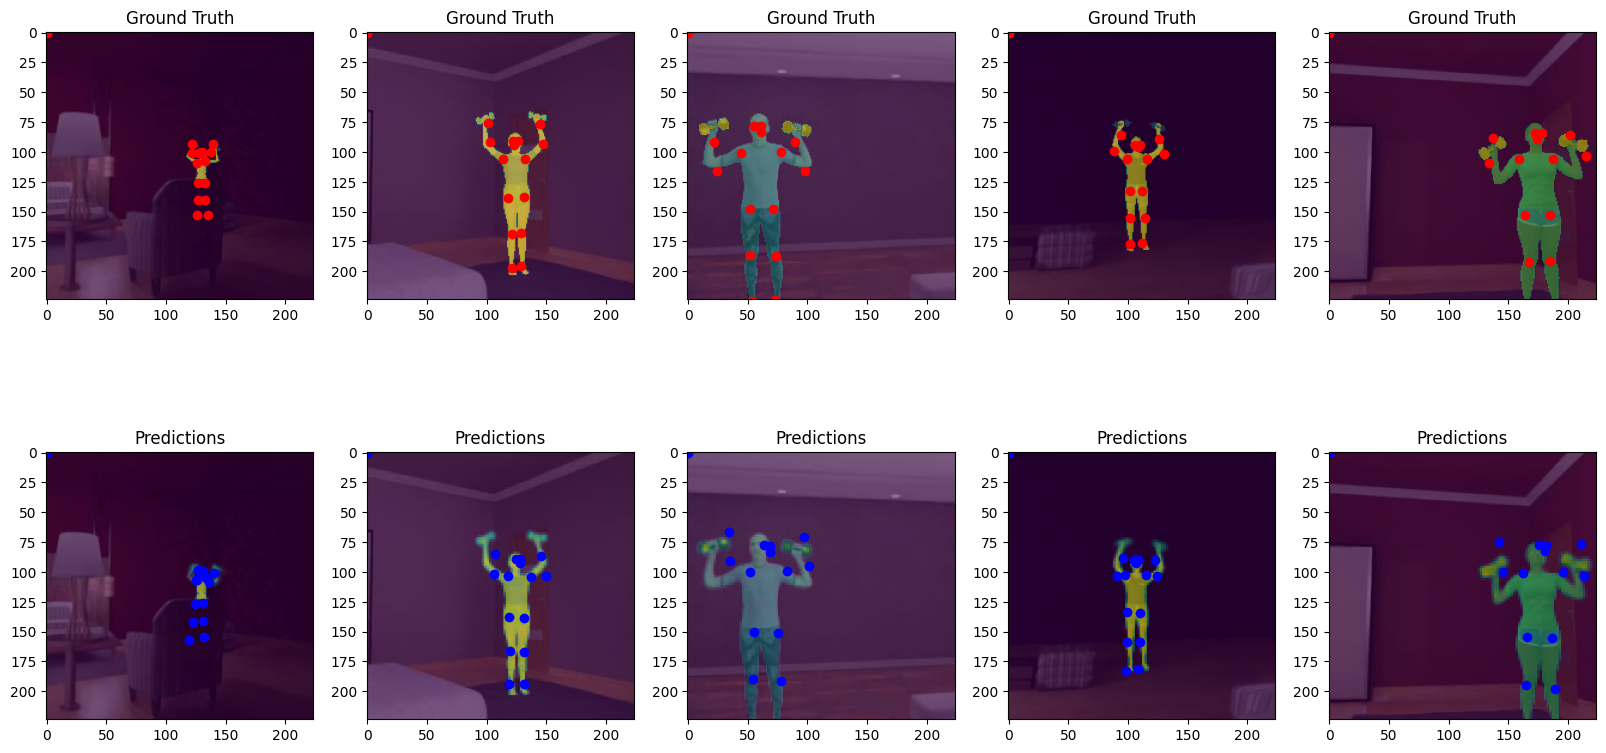

In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_results(images, true_masks, true_keypoints, pred_masks, pred_keypoints):
    """
    Visualize images, ground truth masks and keypoints, and predicted masks and keypoints.

    Args:
        images (torch.Tensor): Batch of images of shape (batch_size, C, H, W).
        true_masks (torch.Tensor): Ground truth masks of shape (batch_size, 1, H, W).
        true_keypoints (torch.Tensor): Ground truth keypoints of shape (batch_size, num_keypoints, 3).
        pred_masks (torch.Tensor): Predicted masks of shape (batch_size, 1, H, W).
        pred_keypoints (torch.Tensor): Predicted keypoints of shape (batch_size, num_keypoints, 3).
    """
    # Create a 2x5 grid of subplots
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))

    for i in range(5):
        # Plot ground truth
        axs[0, i].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        axs[0, i].scatter(
            true_keypoints[i][:, 0] * images[i].shape[2],  # X-coordinates
            true_keypoints[i][:, 1] * images[i].shape[1],  # Y-coordinates
            c='r', marker='o', s=10  # Red keypoints with circle markers
        )
        axs[0, i].imshow(true_masks[i].permute(1, 2, 0).cpu().numpy(), alpha=0.5)
        axs[0, i].set_title('Ground Truth')
        axs[0, i].axis('off')  # Hide axes

        # Plot predictions
        axs[1, i].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        axs[1, i].scatter(
            pred_keypoints[i][:, 0] * images[i].shape[2],  # X-coordinates
            pred_keypoints[i][:, 1] * images[i].shape[1],  # Y-coordinates
            c='b', marker='o', s=10  # Blue keypoints with circle markers
        )
        axs[1, i].imshow(pred_masks[i].permute(1, 2, 0).cpu().numpy(), alpha=0.5)
        axs[1, i].set_title('Predictions')
        axs[1, i].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

def evaluate_model_on_sample(dataloader, model, device):
    """
    Evaluate the model on a sample from the dataloader and visualize results.

    Args:
        dataloader (DataLoader): DataLoader providing batches of data.
        model (nn.Module): The model to evaluate.
        device (torch.device): Device to perform evaluation on ('cpu' or 'cuda').
    """
    model.eval()
    with torch.no_grad():
        # Get a batch of data
        for images, true_masks, true_keypoints in dataloader:
            images = images.to(device)
            true_masks = true_masks.to(device)
            true_keypoints = true_keypoints.to(device)

            # Perform inference
            pred_masks, pred_keypoints = model(images)

            # Visualize results
            visualize_results(images.cpu(), true_masks.cpu(), true_keypoints.cpu(), pred_masks.cpu(), pred_keypoints.cpu())
            break  # Evaluate only the first batch

# Evaluate and visualize results
evaluate_model_on_sample(dataloader, model, device)
